In [1]:
import sys

sys.path.append("..")
from cge_modeling import CGEModel, Variable, Parameter, Equation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp

In [2]:
data = np.array(
    [
        [0, 0, 0, 1000, 2000, 4000],
        [0, 0, 0, 500, 2000, 500],
        [7000, 3000, 0, 0, 0, 0],
        [0, 0, 2000, 1000, 1000, 1000],
        [0, 0, 2500, 2000, 3500, 3000],
        [0, 0, 5500, 500, 2500, 1000],
    ]
)

cols = ["Ld", "Kd", "Men", "Ag", "Ind", "Serv"]
df = pd.DataFrame(data, columns=cols, index=cols, dtype="float64")
df

,Ld,Kd,Men,Ag,Ind,Serv
Ld,0.0,0.0,0.0,1000.0,2000.0,4000.0
Kd,0.0,0.0,0.0,500.0,2000.0,500.0
Men,7000.0,3000.0,0.0,0.0,0.0,0.0
Ag,0.0,0.0,2000.0,1000.0,1000.0,1000.0
Ind,0.0,0.0,2500.0,2000.0,3500.0,3000.0
Serv,0.0,0.0,5500.0,500.0,2500.0,1000.0


In [3]:
def leontief(
    output: sp.Symbol,
    output_price: sp.Symbol,
    inputs: list[sp.Symbol],
    input_prices: list[sp.Symbol],
    params: list[sp.Symbol],
):
    if len(inputs) != len(params):
        raise ValueError("The length of the params should be len(inputs)")

    system = [
        f"{output_price} * {output} -"
        + "-".join([f"{P} * {x}" for P, x in zip(input_prices, inputs)])
    ]
    for factor, param in zip(inputs, params):
        system.append(f"{factor} - {param} * {output}")

    return system

In [4]:
variable_info = [
    Variable(name="Y", dims="i", description="Total output of good <dim:i>"),
    Variable(name="VA", dims="i", description="Labor-capital bundle produced by sector <dim:i>"),
    Variable(
        name="IC", dims="i", description="Intermediate goods bundle produced by sector <dim:i>"
    ),
    Variable(
        name="CIJ", dims=("i", "j"), description="Demand for sector <dim:i> goods by sector <dim:j>"
    ),
    Variable(name="C", dims="i", description="Household consumption of good <dim:i>"),
    Variable(
        name="L_d", dims="i", extend_subscript=True, description="Labor demanded by sector <dim:i>"
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demanded by sector <dim:i>",
    ),
    Variable(name="P", dims="i", description="Price level of final goods in sector <dim:i>"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the labor-capital bundle in sector <dim:i>",
    ),
    Variable(
        name="P_IC",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate bundle in sector <dim:i>",
    ),
    Variable(name="U", description="Household utility"),
    Variable(name="income", latex_name="Omega", description="Total household income"),
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    Parameter(
        name="psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of labor-capital in sector <dim:i>'s final good",
    ),
    Parameter(
        name="psi_IC",
        extend_subscript=True,
        dims="i",
        description="Share of intermediate goods bundle in sector <dim:i>'s final product",
    ),
    Parameter(
        name="psi_CIJ",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of sector <dim:i>'s final good in sector <dim:j>'s intermediate goods bundle",
    ),
    Parameter(
        name="alpha",
        dims="i",
        description="Share of capital in sector <dim:i>'s production process",
    ),
    Parameter(
        name="gamma",
        dims="i",
        description="Household utility weight on consumption of sector <dim:i> goods",
    ),
    Parameter(name="A", dims="i", description="Total factor productivity in sector <dim:i>"),
    Parameter(name="L_s", description="Exogenous household labor supply"),
    Parameter(name="K_s", description="Exogenous household capital stock"),
    Parameter(
        name="P_Ag_bar",
        latex_name=r"\bar{P}_{Ag}",
        description="Exogenous agricultural price level",
    ),
]

equations = [
    Equation("Final good production of sector <dim:i>", "P * Y = P_IC * IC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "IC = psi_IC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    Equation("Sector <dim:i> production of labor-capital", "VA = A * K_d^alpha * L_d^(1-alpha)"),
    Equation("Sector <dim:i> demand for capital", "K_d = alpha * VA * P_VA / r"),
    Equation("Sector <dim:i> demand for labor", "L_d = (1 - alpha) * VA * P_VA / w"),
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "IC * P_IC = Sum(P.subs({i:j}) * CIJ.subs([(i,k), (j,i), (k,j)]), (j, 0, 2))",
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input",
        "CIJ = psi_CIJ * IC.subs({i:j})",
    ),
    Equation("Household income", "income = w * L_s + r * K_s"),
    Equation("Household utility", "U = Product(C**gamma, (i, 0, 2))"),
    Equation("Household demand for good <dim:i>", "C = gamma * income / P"),
    Equation("Labor market clearing", "L_s = Sum(L_d, (i, 0, 2)) + resid"),
    Equation("Capital market clearing", "K_s = Sum(K_d, (i, 0, 2))"),
    Equation("Sector <dim:i> goods market clearing", "Y = C + Sum(CIJ, (j, 0, 2))"),
    Equation("Numeraire", 'P.subs({i:"Ag"}) = P_Ag_bar'),
]

In [5]:
from itertools import product


def _validate_dims(obj, dims, on_unused_dim="raise"):
    unknown_dims = set(dims) - set(obj.dims)
    if len(unknown_dims) > 0:
        unk_str = ", ".join(list(unknown_dims))
        if on_unused_dim == "raise":
            raise ValueError(
                f"Dimension expansion was requested for {obj.name} on the following dims "
                f"which are not associted with {obj.name}: {unk_str}"
            )
        elif on_unused_dim == "ignore":
            return list(set(dims) - unknown_dims)

    return dims


def expand_obj_by_indices(obj, coords, dims=None, on_unused_dim="raise"):
    out = []

    dims = obj.dims if dims is None else dims
    dims = _validate_dims(obj, dims, on_unused_dim)

    labels = [coords[dim] for dim in dims]
    label_prod = product(*labels)

    for labels in label_prod:
        new_obj = obj.copy()
        for dim, label in zip(dims, labels):
            new_obj.update_dim_value(dim, label)
        out.append(new_obj)
    return out

In [6]:
sectors = ["Ag", "Ind", "Serv"]
coords = {"i": sectors, "j": sectors}

In [7]:
mod = CGEModel(variables=variable_info, parameters=param_info, equations=equations, coords=coords)

In [8]:
mod.equation_table()

<IPython.core.display.Latex object>

In [9]:
initial_values = {"P_Ag_bar": 1, "w": 1, "r": 1, "resid": 0}
initial_values.update({f"P_{s}": 1 for s in sectors})
initial_values.update({f"P_VA_{s}": 1 for s in sectors})
initial_values.update({f"P_IC_{s}": 1 for s in sectors})

for sector in sectors:
    initial_values[f"L_d_{sector}"] = df.loc["Ld", sector]
    initial_values[f"K_d_{sector}"] = df.loc["Kd", sector]
    initial_values[f"VA_{sector}"] = (
        initial_values["w"] * initial_values[f"L_d_{sector}"]
        + initial_values["r"] * initial_values[f"K_d_{sector}"]
    ) / initial_values[f"P_VA_{sector}"]
    for sector_j in sectors:
        initial_values[f"CIJ_{sector}_{sector_j}"] = df.loc[sector_j, sector]

In [10]:
initial_res = mod.calibrate(data=initial_values)
initial_res.success

True

In [11]:
initial_res.to_frame()["fitted"][[f"A_{s}" for s in sectors]]

A_Ag      1.889882
A_Ind     2.000000
A_Serv    1.417411
Name: fitted, dtype: float64

In [12]:
capital_supply_res = mod.simulate(
    initial_res,
    final_delta_pct={"K_s": 1.1},
    name="10% Capital Supply Increase",
    method="trust-krylov",
)

<Axes: >

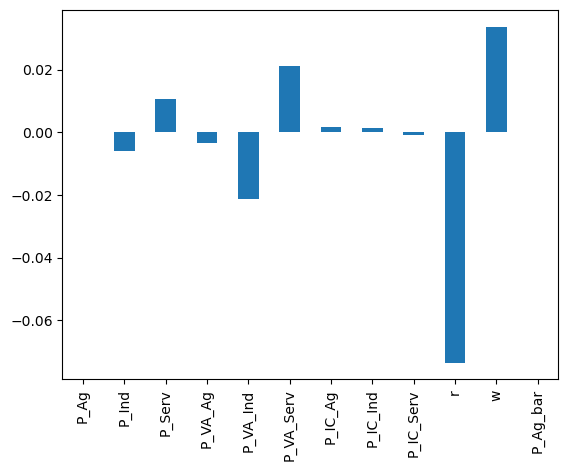

In [27]:
capital_supply_res.to_frame().pct_change(axis=1)["fitted"].loc[
    lambda x: x.index.str.startswith("P") | x.index.isin(["r", "w"])
].plot.bar()

In [13]:
capital_supply_res.success

True

In [14]:
labor_supply_res = mod.simulate(
    initial_res,
    final_delta_pct={"L_s": 1.1},
    n_iter_euler=10,
    name="10% Labor Supply Increase",
    method="trust-krylov",
)

In [15]:
capital_supply_res.to_frame().assign(pct_change=lambda x: x.fitted / x.initial * 100 - 100)

,initial,fitted,pct_change
Y_Ag,4500.000000,4636.835175,3.040782
Y_Ind,12500.000000,12901.780189,3.214242
Y_Serv,8500.000000,8716.685543,2.549242
VA_Ag,1500.000000,1545.611720,3.040781
VA_Ind,4000.000000,4128.569657,3.214241
...,...,...,...
A_Ind,2.000000,2.000000,0.000000
A_Serv,1.417411,1.417411,0.000000
L_s,7000.000000,7000.000000,0.000000
K_s,3000.000000,3300.000000,10.000000


In [16]:
scenario_df = pd.merge(
    (
        capital_supply_res.to_frame()
        .pct_change(axis=1)[["fitted"]]
        .rename(columns={"fitted": "K_shock"})
    ),
    (
        labor_supply_res.to_frame()
        .pct_change(axis=1)[["fitted"]]
        .rename(columns={"fitted": "L_shock"})
    ),
    left_index=True,
    right_index=True,
)

In [17]:
scenario_df.mul(100)

,K_shock,L_shock
Y_Ag,3.040782,6.729516
Y_Ind,3.214242,6.547021
Y_Serv,2.549242,7.242342
VA_Ag,3.040781,6.729516
VA_Ind,3.214241,6.547021
...,...,...
A_Ind,0.000000,0.000000
A_Serv,0.000000,0.000000
L_s,0.000000,10.000000
K_s,10.000000,0.000000
